# Method 8 - Best Ideas DGTW Select

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

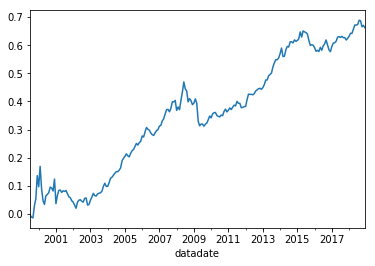

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.136489
2000-12-31   -0.010952
2001-12-31   -0.068426
2002-12-31   -0.012536
2003-12-31    0.062135
2004-12-31    0.091028
2005-12-31    0.050045
2006-12-31    0.033271
2007-12-31    0.079892
2008-12-31   -0.010765
2009-12-31   -0.029004
2010-12-31    0.010673
2011-12-31    0.013895
2012-12-31    0.044461
2013-12-31    0.077081
2014-12-31    0.038235
2015-12-31   -0.008523
2016-12-31   -0.014434
2017-12-31    0.030078
2018-12-31    0.023070
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     13.19
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-09
Time:                        06:49:54   Log-Likelihood:                 686.39
No. Observations:                 234   AIC:                            -1363.
Df Residuals:                     229   BIC:                            -1346.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.377      0.170      -0.001       0.003
mktrf          0.0325      0.024      1.338      0.182      -0.015       0.080
me             0.1726      0.028      6.113      0.000       0.117       0.228
ia            -0.1536      0.043     -3.578      0.000      -0.238      -0.069
roe            0.1536      0.037      4.180      0.000       0.081       0.226
==============================================================================
Omnibus:                       77.356   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1138.057
Skew:                          -0.821   Prob(JB):                    7.48e-248
Kurtosis:                      13.678   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     5.176
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000521
Time:                        06:49:54   Log-Likelihood:                 686.39
No. Observations:                 234   AIC:                            -1363.
Df Residuals:                     229   BIC:                            -1346.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.343      0.179      -0.001       0.003
mktrf          0.0325      0.034      0.965      0.334      -0.033       0.098
me             0.1726      0.063      2.731      0.006       0.049       0.297
ia            -0.1536      0.119     -1.294      0.196      -0.386       0.079
roe            0.1536      0.067      2.283      0.022       0.022       0.285
==============================================================================
Omnibus:                       77.356   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1138.057
Skew:                          -0.821   Prob(JB):                    7.48e-248
Kurtosis:                      13.678   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     4.249
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00246
Time:                        06:49:54   Log-Likelihood:                 686.39
No. Observations:                 234   AIC:                            -1363.
Df Residuals:                     229   BIC:                            -1346.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.217      0.224      -0.001       0.003
mktrf          0.0325      0.026      1.254      0.210      -0.018       0.083
me             0.1726      0.069      2.493      0.013       0.037       0.308
ia            -0.1536      0.101     -1.517      0.129      -0.352       0.045
roe            0.1536      0.058      2.657      0.008       0.040       0.267
==============================================================================
Omnibus:                       77.356   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1138.057
Skew:                          -0.821   Prob(JB):                    7.48e-248
Kurtosis:                      13.678   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     8.112
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.60e-07
Time:                        06:49:54   Log-Likelihood:                 681.29
No. Observations:                 234   AIC:                            -1351.
Df Residuals:                     228   BIC:                            -1330.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.073      0.039    9.42e-05       0.004
mktrf          0.0042      0.025      0.170      0.865      -0.045       0.053
smb            0.1237      0.033      3.761      0.000       0.059       0.188
hml           -0.1482      0.039     -3.823      0.000      -0.225      -0.072
rmw            0.0170      0.044      0.388      0.699      -0.069       0.103
cma            0.0651      0.056      1.168      0.244      -0.045       0.175
==============================================================================
Omnibus:                       88.829   Durbin-Watson:                   2.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1394.919
Skew:                          -1.009   Prob(JB):                    1.25e-303
Kurtosis:                      14.790   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     3.016
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0117
Time:                        06:49:54   Log-Likelihood:                 681.29
No. Observations:                 234   AIC:                            -1351.
Df Residuals:                     228   BIC:                            -1330.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.338      0.019       0.000       0.004
mktrf          0.0042      0.025      0.171      0.864      -0.044       0.053
smb            0.1237      0.052      2.378      0.017       0.022       0.226
hml           -0.1482      0.046     -3.211      0.001      -0.239      -0.058
rmw            0.0170      0.053      0.318      0.750      -0.088       0.122
cma            0.0651      0.135      0.482      0.630      -0.199       0.330
==============================================================================
Omnibus:                       88.829   Durbin-Watson:                   2.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1394.919
Skew:                          -1.009   Prob(JB):                    1.25e-303
Kurtosis:                      14.790   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     3.163
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00881
Time:                        06:49:54   Log-Likelihood:                 681.29
No. Observations:                 234   AIC:                            -1351.
Df Residuals:                     228   BIC:                            -1330.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.107      0.035       0.000       0.004
mktrf          0.0042      0.020      0.208      0.835      -0.036       0.044
smb            0.1237      0.046      2.687      0.007       0.033       0.214
hml           -0.1482      0.050     -2.965      0.003      -0.246      -0.050
rmw            0.0170      0.046      0.373      0.709      -0.072       0.106
cma            0.0651      0.138      0.471      0.638      -0.206       0.336
==============================================================================
Omnibus:                       88.829   Durbin-Watson:                   2.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1394.919
Skew:                          -1.009   Prob(JB):                    1.25e-303
Kurtosis:                      14.790   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     62.38
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.37e-35
Time:                        06:49:54   Log-Likelihood:                 748.36
No. Observations:                 234   AIC:                            -1487.
Df Residuals:                     229   BIC:                            -1469.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.471      0.143      -0.000       0.002
mktrf          0.0882      0.017      5.141      0.000       0.054       0.122
smb            0.0507      0.021      2.369      0.019       0.009       0.093
hml           -0.0479      0.021     -2.250      0.025      -0.090      -0.006
umd            0.1876      0.014     13.440      0.000       0.160       0.215
==============================================================================
Omnibus:                       56.355   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.449
Skew:                          -0.837   Prob(JB):                     4.18e-60
Kurtosis:                       8.024   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     16.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.41e-12
Time:                        06:49:54   Log-Likelihood:                 748.36
No. Observations:                 234   AIC:                            -1487.
Df Residuals:                     229   BIC:                            -1469.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.449      0.147      -0.000       0.002
mktrf          0.0882      0.026      3.437      0.001       0.038       0.138
smb            0.0507      0.034      1.494      0.135      -0.016       0.117
hml           -0.0479      0.042     -1.138      0.255      -0.130       0.035
umd            0.1876      0.032      5.803      0.000       0.124       0.251
==============================================================================
Omnibus:                       56.355   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.449
Skew:                          -0.837   Prob(JB):                     4.18e-60
Kurtosis:                       8.024   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     16.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.79e-12
Time:                        06:49:54   Log-Likelihood:                 748.36
No. Observations:                 234   AIC:                            -1487.
Df Residuals:                     229   BIC:                            -1469.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.292      0.196      -0.001       0.002
mktrf          0.0882      0.023      3.869      0.000       0.044       0.133
smb            0.0507      0.024      2.104      0.035       0.003       0.098
hml           -0.0479      0.036     -1.347      0.178      -0.117       0.022
umd            0.1876      0.034      5.457      0.000       0.120       0.255
==============================================================================
Omnibus:                       56.355   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.449
Skew:                          -0.837   Prob(JB):                     4.18e-60
Kurtosis:                       8.024   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     9.994
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.62e-07
Time:                        06:49:54   Log-Likelihood:                 324.65
No. Observations:                 120   AIC:                            -639.3
Df Residuals:                     115   BIC:                            -625.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.187      0.852      -0.003       0.003
mktrf          0.0771      0.043      1.811      0.073      -0.007       0.161
me             0.2317      0.042      5.508      0.000       0.148       0.315
ia            -0.1597      0.066     -2.425      0.017      -0.290      -0.029
roe            0.2445      0.058      4.194      0.000       0.129       0.360
==============================================================================
Omnibus:                       29.829   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.491
Skew:                          -0.562   Prob(JB):                     4.74e-39
Kurtosis:                       8.834   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     6.551
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.73e-05
Time:                        06:49:54   Log-Likelihood:                 324.65
No. Observations:                 120   AIC:                            -639.3
Df Residuals:                     115   BIC:                            -625.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.183      0.855      -0.003       0.003
mktrf          0.0771      0.059      1.307      0.191      -0.039       0.193
me             0.2317      0.076      3.057      0.002       0.083       0.380
ia            -0.1597      0.148     -1.076      0.282      -0.451       0.131
roe            0.2445      0.081      3.020      0.003       0.086       0.403
==============================================================================
Omnibus:                       29.829   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.491
Skew:                          -0.562   Prob(JB):                     4.74e-39
Kurtosis:                       8.834   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     6.160
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000158
Time:                        06:49:54   Log-Likelihood:                 324.65
No. Observations:                 120   AIC:                            -639.3
Df Residuals:                     115   BIC:                            -625.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.166      0.868      -0.003       0.004
mktrf          0.0771      0.044      1.737      0.082      -0.010       0.164
me             0.2317      0.084      2.768      0.006       0.068       0.396
ia            -0.1597      0.132     -1.211      0.226      -0.418       0.099
roe            0.2445      0.060      4.065      0.000       0.127       0.362
==============================================================================
Omnibus:                       29.829   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.491
Skew:                          -0.562   Prob(JB):                     4.74e-39
Kurtosis:                       8.834   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     4.577
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000767
Time:                        06:49:54   Log-Likelihood:                 317.73
No. Observations:                 120   AIC:                            -623.5
Df Residuals:                     114   BIC:                            -606.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.853      0.396      -0.002       0.005
mktrf          0.0105      0.048      0.219      0.827      -0.084       0.105
smb            0.1627      0.054      3.007      0.003       0.056       0.270
hml           -0.1753      0.066     -2.643      0.009      -0.307      -0.044
rmw            0.0548      0.078      0.701      0.485      -0.100       0.210
cma            0.1067      0.086      1.246      0.215      -0.063       0.276
==============================================================================
Omnibus:                       38.296   Durbin-Watson:                   2.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.569
Skew:                          -0.837   Prob(JB):                     7.03e-52
Kurtosis:                       9.657   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     2.628
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0274
Time:                        06:49:54   Log-Likelihood:                 317.73
No. Observations:                 120   AIC:                            -623.5
Df Residuals:                     114   BIC:                            -606.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      0.988      0.323      -0.001       0.004
mktrf          0.0105      0.052      0.202      0.840      -0.091       0.112
smb            0.1627      0.073      2.230      0.026       0.020       0.306
hml           -0.1753      0.068     -2.564      0.010      -0.309      -0.041
rmw            0.0548      0.080      0.688      0.491      -0.101       0.211
cma            0.1067      0.166      0.642      0.521      -0.219       0.433
==============================================================================
Omnibus:                       38.296   Durbin-Watson:                   2.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.569
Skew:                          -0.837   Prob(JB):                     7.03e-52
Kurtosis:                       9.657   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     3.071
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0122
Time:                        06:49:54   Log-Likelihood:                 317.73
No. Observations:                 120   AIC:                            -623.5
Df Residuals:                     114   BIC:                            -606.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.882      0.378      -0.002       0.005
mktrf          0.0105      0.048      0.218      0.828      -0.084       0.105
smb            0.1627      0.062      2.630      0.009       0.041       0.284
hml           -0.1753      0.073     -2.386      0.017      -0.319      -0.031
rmw            0.0548      0.070      0.780      0.435      -0.083       0.193
cma            0.1067      0.167      0.640      0.522      -0.220       0.433
==============================================================================
Omnibus:                       38.296   Durbin-Watson:                   2.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.569
Skew:                          -0.837   Prob(JB):                     7.03e-52
Kurtosis:                       9.657   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     46.03
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.90e-23
Time:                        06:49:55   Log-Likelihood:                 364.11
No. Observations:                 120   AIC:                            -718.2
Df Residuals:                     115   BIC:                            -704.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.185      0.238      -0.001       0.004
mktrf          0.1293      0.027      4.787      0.000       0.076       0.183
smb            0.0400      0.031      1.300      0.196      -0.021       0.101
hml           -0.0413      0.031     -1.342      0.182      -0.102       0.020
umd            0.2238      0.019     11.785      0.000       0.186       0.261
==============================================================================
Omnibus:                       31.628   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.283
Skew:                          -1.019   Prob(JB):                     7.41e-17
Kurtosis:                       6.271   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     26.20
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.90e-15
Time:                        06:49:55   Log-Likelihood:                 364.11
No. Observations:                 120   AIC:                            -718.2
Df Residuals:                     115   BIC:                            -704.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.168      0.243      -0.001       0.004
mktrf          0.1293      0.036      3.579      0.000       0.058       0.200
smb            0.0400      0.038      1.040      0.298      -0.035       0.115
hml           -0.0413      0.048     -0.869      0.385      -0.135       0.052
umd            0.2238      0.032      6.886      0.000       0.160       0.287
==============================================================================
Omnibus:                       31.628   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.283
Skew:                          -1.019   Prob(JB):                     7.41e-17
Kurtosis:                       6.271   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     33.37
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.84e-18
Time:                        06:49:55   Log-Likelihood:                 364.11
No. Observations:                 120   AIC:                            -718.2
Df Residuals:                     115   BIC:                            -704.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.065      0.287      -0.001       0.004
mktrf          0.1293      0.025      5.197      0.000       0.081       0.178
smb            0.0400      0.024      1.645      0.100      -0.008       0.088
hml           -0.0413      0.043     -0.970      0.332      -0.125       0.042
umd            0.2238      0.030      7.551      0.000       0.166       0.282
==============================================================================
Omnibus:                       31.628   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.283
Skew:                          -1.019   Prob(JB):                     7.41e-17
Kurtosis:                       6.271   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     6.433
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000110
Time:                        06:49:55   Log-Likelihood:                 417.56
No. Observations:                 114   AIC:                            -825.1
Df Residuals:                     109   BIC:                            -811.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.117      0.002       0.001       0.003
mktrf          0.0249      0.019      1.333      0.185      -0.012       0.062
me             0.0141      0.029      0.489      0.626      -0.043       0.071
ia            -0.1745      0.040     -4.363      0.000      -0.254      -0.095
roe           -0.0487      0.035     -1.385      0.169      -0.118       0.021
==============================================================================
Omnibus:                        1.141   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.822
Skew:                          -0.201   Prob(JB):                        0.663
Kurtosis:                       3.108   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     4.589
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00183
Time:                        06:49:55   Log-Likelihood:                 417.56
No. Observations:                 114   AIC:                            -825.1
Df Residuals:                     109   BIC:                            -811.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.084      0.002       0.001       0.003
mktrf          0.0249      0.018      1.417      0.156      -0.010       0.059
me             0.0141      0.041      0.347      0.729      -0.066       0.094
ia            -0.1745      0.048     -3.630      0.000      -0.269      -0.080
roe           -0.0487      0.043     -1.129      0.259      -0.133       0.036
==============================================================================
Omnibus:                        1.141   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.822
Skew:                          -0.201   Prob(JB):                        0.663
Kurtosis:                       3.108   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     4.372
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00257
Time:                        06:49:55   Log-Likelihood:                 417.56
No. Observations:                 114   AIC:                            -825.1
Df Residuals:                     109   BIC:                            -811.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.615      0.009       0.000       0.003
mktrf          0.0249      0.016      1.593      0.111      -0.006       0.055
me             0.0141      0.039      0.365      0.715      -0.062       0.090
ia            -0.1745      0.046     -3.817      0.000      -0.264      -0.085
roe           -0.0487      0.037     -1.306      0.191      -0.122       0.024
==============================================================================
Omnibus:                        1.141   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.822
Skew:                          -0.201   Prob(JB):                        0.663
Kurtosis:                       3.108   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     7.770
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.82e-06
Time:                        06:49:55   Log-Likelihood:                 422.99
No. Observations:                 114   AIC:                            -834.0
Df Residuals:                     108   BIC:                            -817.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.973      0.004       0.001       0.003
mktrf          0.0325      0.017      1.909      0.059      -0.001       0.066
smb            0.0225      0.028      0.812      0.419      -0.032       0.077
hml           -0.0912      0.035     -2.583      0.011      -0.161      -0.021
rmw           -0.0770      0.043     -1.781      0.078      -0.163       0.009
cma           -0.0999      0.055     -1.821      0.071      -0.209       0.009
==============================================================================
Omnibus:                        2.852   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                2.269
Skew:                          -0.268   Prob(JB):                        0.322
Kurtosis:                       3.436   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     5.337
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000201
Time:                        06:49:55   Log-Likelihood:                 422.99
No. Observations:                 114   AIC:                            -834.0
Df Residuals:                     108   BIC:                            -817.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.152      0.002       0.001       0.003
mktrf          0.0325      0.019      1.691      0.091      -0.005       0.070
smb            0.0225      0.030      0.757      0.449      -0.036       0.081
hml           -0.0912      0.037     -2.455      0.014      -0.164      -0.018
rmw           -0.0770      0.038     -2.053      0.040      -0.151      -0.003
cma           -0.0999      0.055     -1.816      0.069      -0.208       0.008
==============================================================================
Omnibus:                        2.852   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                2.269
Skew:                          -0.268   Prob(JB):                        0.322
Kurtosis:                       3.436   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     6.147
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.74e-05
Time:                        06:49:55   Log-Likelihood:                 422.99
No. Observations:                 114   AIC:                            -834.0
Df Residuals:                     108   BIC:                            -817.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.727      0.006       0.001       0.003
mktrf          0.0325      0.019      1.750      0.080      -0.004       0.069
smb            0.0225      0.028      0.798      0.425      -0.033       0.078
hml           -0.0912      0.038     -2.398      0.016      -0.166      -0.017
rmw           -0.0770      0.041     -1.868      0.062      -0.158       0.004
cma           -0.0999      0.048     -2.063      0.039      -0.195      -0.005
==============================================================================
Omnibus:                        2.852   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                2.269
Skew:                          -0.268   Prob(JB):                        0.322
Kurtosis:                       3.436   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     9.155
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.05e-06
Time:                        06:49:55   Log-Likelihood:                 421.99
No. Observations:                 114   AIC:                            -834.0
Df Residuals:                     109   BIC:                            -820.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.169      0.032       0.000       0.003
mktrf          0.0477      0.017      2.802      0.006       0.014       0.081
smb            0.0360      0.027      1.358      0.177      -0.017       0.089
hml           -0.0989      0.027     -3.619      0.000      -0.153      -0.045
umd            0.0480      0.021      2.327      0.022       0.007       0.089
==============================================================================
Omnibus:                        1.690   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.430   Jarque-Bera (JB):                1.256
Skew:                          -0.240   Prob(JB):                        0.534
Kurtosis:                       3.182   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     13.32
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.18e-09
Time:                        06:49:55   Log-Likelihood:                 421.99
No. Observations:                 114   AIC:                            -834.0
Df Residuals:                     109   BIC:                            -820.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.330      0.020       0.000       0.002
mktrf          0.0477      0.017      2.871      0.004       0.015       0.080
smb            0.0360      0.032      1.142      0.253      -0.026       0.098
hml           -0.0989      0.032     -3.080      0.002      -0.162      -0.036
umd            0.0480      0.019      2.566      0.010       0.011       0.085
==============================================================================
Omnibus:                        1.690   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.430   Jarque-Bera (JB):                1.256
Skew:                          -0.240   Prob(JB):                        0.534
Kurtosis:                       3.182   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     13.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.22e-09
Time:                        06:49:55   Log-Likelihood:                 421.99
No. Observations:                 114   AIC:                            -834.0
Df Residuals:                     109   BIC:                            -820.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.135      0.033       0.000       0.003
mktrf          0.0477      0.014      3.427      0.001       0.020       0.075
smb            0.0360      0.033      1.103      0.270      -0.028       0.100
hml           -0.0989      0.033     -3.005      0.003      -0.163      -0.034
umd            0.0480      0.019      2.500      0.012       0.010       0.086
==============================================================================
Omnibus:                        1.690   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.430   Jarque-Bera (JB):                1.256
Skew:                          -0.240   Prob(JB):                        0.534
Kurtosis:                       3.182   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""